#Coursera Applied Data Science Capstone 
Ahmad Keewan <br>
ahmedkeewan@gmail.com<br>
https://github.com/ahmedkeewan<br>
The battle of neighborhoods<br>
Week 5<br>
April 06, 2020<br>

#1- Introduction

Big data is a field that treats ways to analyze, systematically extract information from, or otherwise deal with data sets that are too large or complex to be dealt with by traditional data-processing application software.(wikipedia,Big_data).<br><br>

Geometry and topology are very natural tools for analysing massive amounts of data since geometry can be regarded as the study of distance functions. Mathematical formalism, which has been developed for incorporating geometric and topological techniques, deals with point cloud data sets, i.e. finite sets of points.<br><br>

Amman is one of the most crowded cities in the middle east, given its size and population, almost 4 million people live in the area of 1,680 km² with tons and tons of restaurants and venues, Amman is famous for its diversity, which makes opening a new small business kind of risky<br><br>


1.1 Problem:<br>
I need to compare different areas within the city of Amman,Jordan to recommend the hottest spots for an imaginary contactor who is planning to open a restaurant or any other business in a popular area.


1.2 Interest:<br>
Anyone with small money capital planning to open a new business, would be very interested in checking the hottest or dense places before choosing where their business is going to take place, to avoid competition and possible loss.  







#2- Data


2.1 Required data:
The data that i need for the project is a geographical dataset that contains the different types of venues located in the city of Amman.
The dataset should consist of the Latitudes,Longitudes,Categories,Neighborhoods and the names of the venues that i will be exploring. <br>

2.2 Data source:<br>
To apply what I have learned during the last couple of weeks while preparing for the capstone, I will use Foursquare api to obtain my data, because it’s free and kind of provides me with what I need.<br>


2.3 How will it solve the problem:<br>
Using the features extracted from the dataset which are the ones mentioned in point 1, we can compute the frequency of the different types of venues in each neighborhood, and accordingly use these frequencies to cluster and recommend the right spots, and by that we solve the problem.

2.4 Data Cleaning:

The collected data from foursquare api was missing a lot of values and contained duplicate or miss-classified categories, so i started with normalizing the json file, then i created a data-frame consisting of the columns i need for my project, i then passed one of the columns to a function to extract the categories of each venue, after that i started merging the categories, where each category that consisted of the word Restaurant was converted to the word restaurant only regardless of its type, same thing was repeated for the neighborhoods where i fixed the ones that were consisting of missing values or miss-classified values, using google maps and the latitude,longitude of each venue.





In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# for webscraping import Beautiful Soup 
from bs4 import BeautifulSoup

import xml

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library



print('Libraries imported.')

/bin/bash: conda: command not found
Libraries imported.


In [3]:
CLIENT_ID = 'VEIAW13PSVIJCXLDKKD00XSQTZF22N3SVTHKL0YIXPNEBVXI' # 
CLIENT_SECRET = 'NT1G41HA3FRFME5NBCGXW2P1D2QYC5GSDVBKDRBOSLSMMZ5P' # 
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: VEIAW13PSVIJCXLDKKD00XSQTZF22N3SVTHKL0YIXPNEBVXI
CLIENT_SECRET:NT1G41HA3FRFME5NBCGXW2P1D2QYC5GSDVBKDRBOSLSMMZ5P


In [4]:
Amman='Amman, Jordan'
agent=Nominatim(user_agent='ahmed')
location=agent.geocode(Amman)
Amman_lat=location.latitude
Amman_lng=location.longitude

print('Location:{} \nCoordinates=({},{})'.format(Amman,Amman_lat,Amman_lng))

Location:Amman, Jordan 
Coordinates=(31.9515694,35.9239625)


In [5]:
amm1=folium.Map(location=[Amman_lat,Amman_lng],zoom_start=12,width='70%',height='70%')
amm1

In [6]:
url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,Amman_lat,Amman_lng,50000*1.5,500)

results=requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e8c1afa02a17200285cde10'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4c8b7c3e770fb60c4526dcc3-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/apparel_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d103951735',
         'name': 'Clothing Store',
         'pluralName': 'Clothing Stores',
         'primary': True,
         'shortName': 'Apparel'}],
       'id': '4c8b7c3e770fb60c4526dcc3',
       'location': {'address': '10 Baouniyyeh Street',
        'cc': 'JO',
        'city': 'Amman',
        'country': 'الأردن',
        'distance': 604,
        'formattedAddress': ['10 Baouniyyeh Street', 'Amman 11191', 'الأردن'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 31.956443487691526,
         

In [0]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [8]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.location.distance','venue.location.neighborhood']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng,distance,neighborhood
0,Jo Bedu (جوبدو),Clothing Store,31.956443,35.926776,604,Jabal Al Lweibdah
1,Rumi Cafe (مقهى رومي),Café,31.956113,35.925881,537,Jabal Al Lweibdah
2,Daret Al Funoon دارة الفنون,Art Gallery,31.954056,35.930238,654,NaN
3,Fakhr Al Din (مطعم فخر الدين),Middle Eastern Restaurant,31.952205,35.920381,345,NaN
4,Wild Jordan (برية الاردن),Middle Eastern Restaurant,31.950970,35.930872,656,Jabal Amman
5,Levant Restaurant,Mediterranean Restaurant,31.952475,35.907302,1576,NaN
6,Gerard (جيرارد),Ice Cream Shop,31.949084,35.928263,491,NaN
7,Oliva (أوليفا),Italian Restaurant,31.956819,35.926078,617,Weibdeh
8,The Boulevard (البوليڤارد),Plaza,31.964526,35.905431,2267,NaN
9,Prime Cinemas,Movie Theater,31.964030,35.908342,2025,NaN


In [0]:
nearby_venues['neighborhood'].replace(np.nan,'Amman',inplace=True)

In [10]:
nearby_venues.head()

,name,categories,lat,lng,distance,neighborhood
0,Jo Bedu (جوبدو),Clothing Store,31.956443,35.926776,604,Jabal Al Lweibdah
1,Rumi Cafe (مقهى رومي),Café,31.956113,35.925881,537,Jabal Al Lweibdah
2,Daret Al Funoon دارة الفنون,Art Gallery,31.954056,35.930238,654,Amman
3,Fakhr Al Din (مطعم فخر الدين),Middle Eastern Restaurant,31.952205,35.920381,345,Amman
4,Wild Jordan (برية الاردن),Middle Eastern Restaurant,31.950970,35.930872,656,Jabal Amman


In [11]:
amm2=folium.Map(location=[Amman_lat,Amman_lng],zoom_start=15,width='100%',height='100%')


for lat,lng,cat in zip(nearby_venues.lat,nearby_venues.lng,nearby_venues.categories):
  label='{}'.format(cat)
  folium.CircleMarker(location=[lat,lng],radius=2,popup=label).add_to(amm2)

amm2

In [12]:
nearby_venues['categories'].value_counts()

Café                         11
Coffee Shop                   8
Middle Eastern Restaurant     6
Hotel                         6
Bakery                        5
Ice Cream Shop                5
Dessert Shop                  5
Historic Site                 3
Burger Joint                  3
Falafel Restaurant            3
Wings Joint                   2
Supermarket                   2
Italian Restaurant            2
Steakhouse                    2
Creperie                      2
Hot Dog Joint                 2
Fast Food Restaurant          2
Shopping Mall                 2
Juice Bar                     2
Restaurant                    2
Park                          1
Cupcake Shop                  1
Multiplex                     1
Pool                          1
Art Gallery                   1
Sandwich Place                1
Breakfast Spot                1
Mediterranean Restaurant      1
Pedestrian Plaza              1
Gastropub                     1
Snack Place                   1
Pub     

In [15]:
nearby_venues['categories'].loc[(nearby_venues['categories'].str.contains("Restaurant",case=False))] = 'Restaurant'
nearby_venues['categories'].loc[(nearby_venues['categories'].str.contains("bar",case=False))] = 'Bar'
nearby_venues['categories'].loc[(nearby_venues['categories'].str.contains("sandwich",case=False))] = 'Restaurant'
nearby_venues['categories'].loc[(nearby_venues['categories'].str.contains("burger",case=False))] = 'Restaurant'
nearby_venues['categories'].loc[(nearby_venues['categories'].str.contains("wings",case=False))] = 'Restaurant'
nearby_venues['categories'].loc[(nearby_venues['categories'].str.contains("hot dog",case=False))] = 'Restaurant'
nearby_venues['categories'].loc[(nearby_venues['categories'].str.contains("beer",case=False))] = 'Bar'
nearby_venues['categories'].loc[(nearby_venues['categories'].str.contains("plaza",case=False))] = 'Plaza'
nearby_venues['categories'].loc[(nearby_venues['categories'].str.contains("tea",case=False))] = 'Coffee Shop'
nearby_venues['categories'].loc[(nearby_venues['categories'].str.contains("pub",case=False))] = 'Pub'
nearby_venues['categories'].loc[(nearby_venues['categories'].str.contains("diner",case=False))] = 'Restaurant'
nearby_venues['categories'].loc[(nearby_venues['categories'].str.contains("frozen",case=False))] = 'Ice Cream Shop'







/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [16]:

nearby_venues['neighborhood'].loc[(nearby_venues['neighborhood'].str.contains("weibdah",case=False))] = 'Jabal Al Lweibdah'
nearby_venues['neighborhood'].loc[(nearby_venues['neighborhood'].str.contains("jabal amman",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['neighborhood'].str.contains("abdun",case=False))] = 'Abdoun'
nearby_venues['neighborhood'].loc[(nearby_venues['neighborhood'].str.contains("abdoun",case=False))] = 'Abdoun'
nearby_venues['neighborhood'].loc[(nearby_venues['neighborhood'].str.contains("abdoon",case=False))] = 'Abdoun'
nearby_venues['neighborhood'].loc[(nearby_venues['neighborhood'].str.contains("Weibdeh",case=False))] = 'Jabal Al Lweibdah'
nearby_venues['neighborhood'].loc[(nearby_venues['neighborhood'].str.contains("وسط",case=False))] = 'Downtown'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [61]:
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("فخر",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("levant",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("gerard",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("boulev",case=False))] = 'Abdali'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("prime",case=False))] = 'Abdali'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("القدس",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("جبل",case=False))] = 'Downtown'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("عبدلي",case=False))] = 'Abdali'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("prime",case=False))] = 'Abdali'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("حبيبة",case=False))] = 'Downtown'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("سفرة",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("black s",case=False))] = 'Abdali'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("wild",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("daret",case=False))] = 'Jabal Al Lweibdah'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("rench",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("herc",case=False))] = 'Downtown'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("mijana",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("four w",case=False))] = 'Abdoun'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("-wei",case=False))] = 'Jabal Al Lweibdah'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("fairm",case=False))] = 'Al Swaifyeh'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("canta",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("buffal",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("fatat",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("صلاح",case=False))] = 'Abdali'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("باريس",case=False))] = 'Jabal Al Lweibdah'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("dimit",case=False))] = 'Jabal Al Lweibdah'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("السيارات",case=False))] = 'Al Madinah Al Tabyeh'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("الشفا",case=False))] = 'Al Tla\'a Al Shamali'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("abu jba",case=False))] = 'Wasfi At-Tall St.'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("simply co",case=False))] = 'Abdoun'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("dog",case=False))] = 'Abdoun'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("almond",case=False))] = 'Umm Al Summaq'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("adam",case=False))] = 'Abdoun'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("dunia",case=False))] = 'Jabal Amman'
#nearby_venues['neighborhood'].loc[(nearby_venues['distance'].str.contains("4379",case=False))] = 'al rabieh'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("strada",case=False))] = 'Umm Al Summaq'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("mind",case=False))] = 'Al Rabieh'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("amman hotel",case=False))] = 'Abdali'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("crepe",case=False))] = 'Al Rawabi'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("kalbooz",case=False))] = 'Jabal Al Lweibdah'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("zait",case=False))] = 'Abdoun'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("firefly",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("gusti",case=False))] = 'Al Rabieh'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("fitness first",case=False))] = 'Abdoun'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("treats",case=False))] = 'Khilda'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("da esma",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("cocoon",case=False))] = 'Umm Uthainah Al Gharbi'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("yoshi",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("brisket",case=False))] = 'Abdali'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("McDonald's",case=False))] = 'Baraka'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("جميدة",case=False))] = 'Downtown'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("نفيسة",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("zalatimo",case=False))] = 'Abdali'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("العميد",case=False))] = 'Baraka'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("هاشم",case=False))] = 'Downtown'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("مونتاج",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("oud",case=False))] = 'Abdali'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("jafra",case=False))] = 'Downtown'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("tawaheen",case=False))] = 'Al Tla\'a Al Shamali'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("lucca",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("deeritna",case=False))] = 'Abdali'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("oz bout",case=False))] = 'AbdaAl Sahel'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("Lebanese",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("the house",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("Pantastic",case=False))] = 'Jabal Amman'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("blue",case=False))] = 'Abdoun'
nearby_venues['neighborhood'].loc[(nearby_venues['name'].str.contains("the bake",case=False))] = 'Jabal Amman'


nearby_venues

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,name,categories,lat,lng,distance,neighborhood
0,Jo Bedu (جوبدو),Clothing Store,31.956443,35.926776,604,Jabal Al Lweibdah
1,Rumi Cafe (مقهى رومي),Café,31.956113,35.925881,537,Jabal Al Lweibdah
2,Daret Al Funoon دارة الفنون,Art Gallery,31.954056,35.930238,654,Jabal Al Lweibdah
3,Fakhr Al Din (مطعم فخر الدين),Restaurant,31.952205,35.920381,345,Jabal Amman
4,Wild Jordan (برية الاردن),Restaurant,31.950970,35.930872,656,Jabal Amman
5,Levant Restaurant,Restaurant,31.952475,35.907302,1576,Jabal Amman
6,Gerard (جيرارد),Ice Cream Shop,31.949084,35.928263,491,Jabal Amman
7,Oliva (أوليفا),Restaurant,31.956819,35.926078,617,Jabal Al Lweibdah
8,The Boulevard (البوليڤارد),Plaza,31.964526,35.905431,2267,Abdali
9,Prime Cinemas,Movie Theater,31.964030,35.908342,2025,Abdali


#3 Exlaporatory data analysis

In this part of the project I calculated the total number of venues in each neighborhood along with the number of venues in general in the second plot, as we can see the most dense area in Amman is Jabal Amman, followed by Abdoun, Abdali, and Jabal Al Weibdeh.



In [62]:
nearby_venues['categories'].value_counts()

Restaurant        27
Café              11
Coffee Shop       11
Ice Cream Shop     6
Hotel              6
Dessert Shop       5
Bakery             5
Historic Site      3
Bar                3
Pub                2
Creperie           2
Shopping Mall      2
Supermarket        2
Plaza              2
Park               1
Cupcake Shop       1
Gym                1
Multiplex          1
Movie Theater      1
Art Gallery        1
Snack Place        1
Museum             1
Pool               1
Spa                1
Clothing Store     1
Lounge             1
Breakfast Spot     1
Name: categories, dtype: int64

Ellipsis

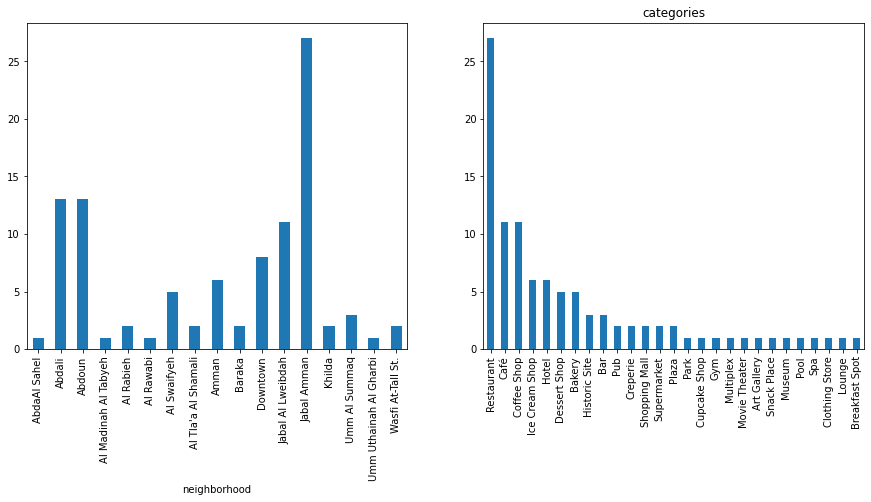

In [123]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
#test_group=amman_onehot.groupby('neighborhood').sum()
#test_group['total]=test_group.sum(axis=1)
test_group['total'].plot(kind='bar')
ax2 = fig.add_subplot(122)
nearby_venues['categories'].value_counts().plot(kind='bar',subplots=True)


...

#Cont.
After that i calculated the frequency of each venue in each neighborhood using the one-hot encoding for each venue in each neighborhood, and using the list of frequencies i created another table consisting of the top 10 venues in each neighborhoods according to their frequencies, and this can be seen in the tables shown down below


In [63]:
# one hot encoding
amman_onehot = pd.get_dummies(nearby_venues[['categories']], prefix="", prefix_sep="")
cols=list(amman_onehot.columns)
# add neighborhood column back to dataframe
amman_onehot['neighborhood'] = nearby_venues['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = ['neighborhood']+list(cols)
amman_onehot = amman_onehot[fixed_columns]

amman_onehot.head()


,neighborhood,Art Gallery,Bakery,Bar,Breakfast Spot,Café,Clothing Store,Coffee Shop,Creperie,Cupcake Shop,Dessert Shop,Gym,Historic Site,Hotel,Ice Cream Shop,Lounge,Movie Theater,Multiplex,Museum,Park,Plaza,Pool,Pub,Restaurant,Shopping Mall,Snack Place,Spa,Supermarket
0,Jabal Al Lweibdah,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Jabal Al Lweibdah,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Jabal Al Lweibdah,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Jabal Amman,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Jabal Amman,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [64]:
amman_grouped = amman_onehot.groupby('neighborhood').mean().reset_index()
amman_grouped

,neighborhood,Art Gallery,Bakery,Bar,Breakfast Spot,Café,Clothing Store,Coffee Shop,Creperie,Cupcake Shop,Dessert Shop,Gym,Historic Site,Hotel,Ice Cream Shop,Lounge,Movie Theater,Multiplex,Museum,Park,Plaza,Pool,Pub,Restaurant,Shopping Mall,Snack Place,Spa,Supermarket
0,AbdaAl Sahel,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,Abdali,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.076923,0.0,0.000000,0.076923,0.000000,0.000,0.307692,0.000000,0.0,0.076923,0.000000,0.0,0.000000,0.076923,0.000000,0.000000,0.230769,0.076923,0.000000,0.0,0.000000
2,Abdoun,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.076923,0.0,0.000000,0.000000,0.076923,0.000,0.000000,0.000000,0.0,0.000000,0.076923,0.0,0.000000,0.000000,0.000000,0.076923,0.384615,0.076923,0.000000,0.0,0.153846
3,Al Madinah Al Tabyeh,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,Al Rabieh,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.500000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
5,Al Rawabi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
6,Al Swaifyeh,0.000000,0.400000,0.200000,0.000000,0.000000,0.000000,0.200000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.200000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
7,Al Tla'a Al Shamali,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000
8,Amman,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.500000,0.0,0.166667,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
9,Baraka,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,0.000000


In [65]:
num_top_venues = 5

for dist in amman_grouped['neighborhood']:
    print("----"+str(dist)+"----")
    temp = amman_grouped[amman_grouped['neighborhood'] == dist].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----AbdaAl Sahel----
           venue  freq
0         Lounge   1.0
1    Art Gallery   0.0
2            Spa   0.0
3    Snack Place   0.0
4  Shopping Mall   0.0


----Abdali----
           venue  freq
0          Hotel  0.31
1     Restaurant  0.23
2  Shopping Mall  0.08
3    Coffee Shop  0.08
4   Dessert Shop  0.08


----Abdoun----
           venue  freq
0     Restaurant  0.38
1    Supermarket  0.15
2           Café  0.08
3  Shopping Mall  0.08
4    Coffee Shop  0.08


----Al Madinah Al Tabyeh----
         venue  freq
0       Museum   1.0
1  Art Gallery   0.0
2       Lounge   0.0
3          Spa   0.0
4  Snack Place   0.0


----Al Rabieh----
            venue  freq
0  Ice Cream Shop   0.5
1            Café   0.5
2          Lounge   0.0
3             Spa   0.0
4     Snack Place   0.0


----Al Rawabi----
         venue  freq
0     Creperie   1.0
1  Art Gallery   0.0
2       Lounge   0.0
3          Spa   0.0
4  Snack Place   0.0


----Al Swaifyeh----
            venue  freq
0          Bakery 

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [67]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

#columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood'] = amman_grouped['neighborhood']

for ind in np.arange(amman_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(amman_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AbdaAl Sahel,Lounge,Supermarket,Hotel,Bakery,Bar,Breakfast Spot,Café,Clothing Store,Coffee Shop,Creperie
1,Abdali,Hotel,Restaurant,Bakery,Shopping Mall,Plaza,Coffee Shop,Movie Theater,Dessert Shop,Supermarket,Gym
2,Abdoun,Restaurant,Supermarket,Gym,Shopping Mall,Pub,Café,Multiplex,Coffee Shop,Bakery,Bar
3,Al Madinah Al Tabyeh,Museum,Supermarket,Hotel,Bakery,Bar,Breakfast Spot,Café,Clothing Store,Coffee Shop,Creperie
4,Al Rabieh,Ice Cream Shop,Café,Hotel,Bakery,Bar,Breakfast Spot,Clothing Store,Coffee Shop,Creperie,Cupcake Shop


#4-Modeling 
In the modeling part of the project i used 2 different methods to model my dataset,
Starting from normal clustering, to plotting the results in 4 different maps.


###4.1 Clustering:
In the clustering part, i used the famous partitional clustering algorithm (kmeans) to generate cluster for the areas of Amman using the dataset that i prepared in the previous sections
To choose the right number of clusters, i used the Elbow-method by plotting the inertias extracted from the kmeans algorithm and matplotlib plot function 


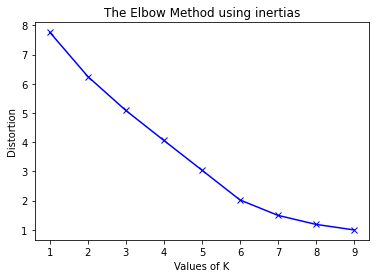

In [131]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(amman_grouped_clustering) 
      
    inertias.append(kmeanModel.inertia_) 
  
    

import matplotlib.pyplot as plt  

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using inertias') 
plt.show()     

In [129]:
# set number of clusters
kclusters = 6

amman_grouped_clustering = amman_grouped.drop('neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(amman_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 4, 1, 2, 1, 5, 1, 1], dtype=int32)

##cont.

As we can see in the plot the perfect K value is either 6 or 7, and after testing both values, i clustered the final results using 6 as the value of K

After clustering, I added the cluster labels to the dataset, then I merged the first dataset with the dataset that consisted of the most common values.


In [71]:
# add clustering labels

amman_merged = nearby_venues
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
amman_merged = amman_merged.join(neighborhoods_venues_sorted.set_index('neighborhood'), on='neighborhood')

amman_merged.head() # check the last columns!

,name,categories,lat,lng,distance,neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Jo Bedu (جوبدو),Clothing Store,31.956443,35.926776,604,Jabal Al Lweibdah,1,Café,Restaurant,Art Gallery,Snack Place,Plaza,Park,Clothing Store,Coffee Shop,Gym,Bakery
1,Rumi Cafe (مقهى رومي),Café,31.956113,35.925881,537,Jabal Al Lweibdah,1,Café,Restaurant,Art Gallery,Snack Place,Plaza,Park,Clothing Store,Coffee Shop,Gym,Bakery
2,Daret Al Funoon دارة الفنون,Art Gallery,31.954056,35.930238,654,Jabal Al Lweibdah,1,Café,Restaurant,Art Gallery,Snack Place,Plaza,Park,Clothing Store,Coffee Shop,Gym,Bakery
3,Fakhr Al Din (مطعم فخر الدين),Restaurant,31.952205,35.920381,345,Jabal Amman,1,Restaurant,Ice Cream Shop,Coffee Shop,Bakery,Bar,Hotel,Pub,Breakfast Spot,Café,Dessert Shop
4,Wild Jordan (برية الاردن),Restaurant,31.950970,35.930872,656,Jabal Amman,1,Restaurant,Ice Cream Shop,Coffee Shop,Bakery,Bar,Hotel,Pub,Breakfast Spot,Café,Dessert Shop



In the next phase of clustering, I created a map using Folium with all of the venues colored according to their clusters label and marked as circles, the map below shows the clustered venues: 


In [72]:
# create map
map_clusters = folium.Map(location=[Amman_lat, Amman_lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(amman_merged['lat'], amman_merged['lng'], amman_merged['neighborhood'], amman_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In the third phase, I used the same clustered dataset, to create another map to create a heat map without the venues, to see confirm that our clustering was able to collect the density of the area of Jabal Amman, as can shown in the following map:

In [73]:
m_5 = folium.Map(location=[Amman_lat,Amman_lng], tiles='cartodbpositron', zoom_start=12)

# Add a heatmap to the base map
HeatMap(good_locations, radius=20).add_to(m_5)

# Display the map
m_5


##Cont.
As we can see in the map above, our clustering was able to detect the density of Jabal Amman correctly.

In the final phase, i merged the two maps to see the point within the heatmap, which can be seen in the map down below:


In [132]:
from folium import plugins

from folium.plugins import HeatMap
good_locations = [[lat, lon] for lat, lon in zip(amman_merged['lat'],amman_merged['lng'])]

map3 = folium.Map(location=[Amman_lat, Amman_lng], zoom_start=14)
HeatMap(good_locations, radius=25).add_to(map3)

for lat, lon ,poi, cluster in zip(amman_merged['lat'], amman_merged['lng'], amman_merged['neighborhood'],amman_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)

    folium.CircleMarker([lat, lon], radius=2, popup=label,color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map3)
map3

##4.2-Folium marker cluster 
In this method i used the marker cluster method provided by folium to cluster the original dataset i cleaned first, to check whether i will get the same results or not:

In [75]:
from folium.plugins import MarkerCluster

popupss = ['{}'.format(neighborh) for (neighborh) in nearby_venues['neighborhood']]
locationsss = list(zip(nearby_venues['lat'], nearby_venues['lng']))

ccc = folium.Map(
    location=[Amman_lat, Amman_lng],
    tiles='Cartodb Positron',
    zoom_start=12
)

marker_cluster = MarkerCluster(
    locations=locationsss, popups=popupss,
    name='1000 clustered icons',
    overlay=True,
    control=True,
    
)

marker_cluster.add_to(ccc)

folium.LayerControl().add_to(ccc)

ccc


#5-Results and discussion 


Our analysis shows that although Amman is a small city, but it has a large number of (Restaurants,Cafes, and Coffee houses), there are pockets of low restaurant density fairly close to(Umm Al Summaq, Al-Rawabi,Al-Swaifyeh,and Al Madinah Al Tabyeh). Highest concentration of restaurants was detected in Jabal Amman, so we wouldn't recommend opening a new restaurant in this area because it's dense and highly competitive.
 
(khilda, Umm Al Summaq, and Umm Uthainah Al Gharbi) are the areas which offer a combination of popularity among locals, closeness to west amman, strong socio-economic dynamics *and* a number of pockets of low restaurant density, so our recommendation for this area is to open a Restaurant not another type of venue.
 
After directing our attention to this more narrow area of interest (Amman) I first created a one-hot matrix of location candidates along with the types of venues in each neighborhood; those locations were then filtered so that I can get a better idea about the popular type of venues in each neighborhood.
 
Those location candidates were then clustered to create zones of heats or trends according to the frequency of each activity in each neighborhood,after that I created 4 maps,2 of which are heat maps, one is a clustering map, and one with the colored circles according to the number of clusters each point follows .
 
Result of all this is the area of Jabal Amman is the most dense/crowded area in Amman, and according to the analysis; Restaurants are the highest frequency venues in the whole city, so as motivating this may look, it's actually not, because opening a new Restaurant the provides the same type of dishes as the ones near it in a dense area would result in a total loss, so whenever someone needs to have an idea of the density and types of venues in the most popular neighborhoods in Amman, they can refer to this study.


#6-Conclusion


Purpose of this project was to identify Amman areas that are popular with a low number of restaurants, in order to aid stakeholders in narrowing down the search for the optimal location for a restaurant. By calculating venue frequency distribution from Foursquare data, I have first collected the venues and neighborhoods that strictly fall in Amman, and then manually fixed the neighborhoods that were filled with null values, using google maps and the lat,long of each venue.

After preparing the data, I created a one-hot matrix for each neighborhood and the venues that are located in it, using the one-hot matrix, I calculated the frequency of each venue and used to the top 5 in each neighborhood, going from that, I then sorted the venues according to their common in a new matrix.

Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and addresses of those zones  were used for final exploration by stakeholders.

Final decision on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like frequency of each venue in each location and its density.